Install dependencies

In [1]:
!pip install -r ../../requirements.txt

Read data.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_folder = './datasets/rating-based-dataset/'

scores_data = pd.read_csv(data_folder + "data/ae_only_unambiguous_1000.csv", low_memory=False)

_images = scores_data['website'].unique()
_scores = scores_data.groupby('website')['mean_response'].apply(list)

del scores_data

Get images path.

In [5]:
all_images = []
scores = []
images_path = data_folder + 'preprocess/resized'

for image in _images:

  # english websites
  if 'english' in image:
    all_images.append(images_path + '/english_resized/' + image[8:] + '.png')
    scores.append(_scores[image])

  # foreign websites
  if 'foreign' in image:
    all_images.append(images_path + '/foreign_resized/' + image[8:] + '.png')  
    scores.append(_scores[image])

print('Total number of images: %d' % len(all_images))

Total number of images: 398


Get the path of the images in test set and the ground truth user aesthetics ratings for each website. 

In [6]:
import csv

test_data_path = data_folder + 'preprocess/test_list.csv'

def get_scores(scores_path):

    images = []
    scores = []

    with open(scores_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0

        for row in csv_reader:
            if line_count == 0:

                line_count += 1
            else:

                scores.append(float(row[1]))
                line_count += 1
                image_name = row[0]

                images.append(images_path + image_name)

    return (images, scores)

test_images_names, gt_scores = get_scores(test_data_path)

Form training and test data 
* {train, test}_images: contains the path of each image
* {train, test}_scores: contains the user ratings of each image

In [7]:
train_images =[]
train_scores =[]

test_images = test_images_names
test_scores = [[]] * len(test_images)

for i in range(0, len(all_images)):
  if all_images[i] in test_images_names:

    pos = test_images_names.index(all_images[i])

    test_scores[pos] = scores[i]
  else:
    train_images.append(all_images[i])
    train_scores.append(scores[i])

Shuffle the training set

In [8]:
import random

# np.random.seed(2000)
    
temp = list(zip(train_images, train_scores))
random.shuffle(temp)

train_images, train_scores = zip(*temp)

Display the first 3 images to make sure everything is ok. 

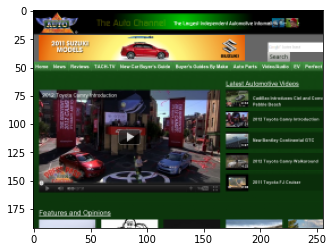

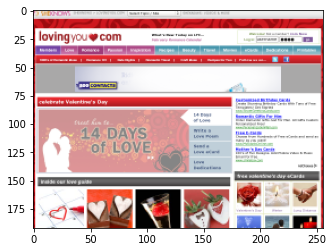

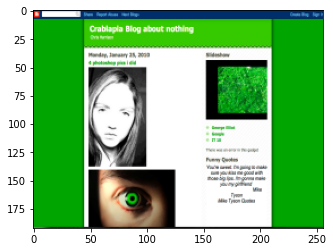

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.image as mping
for ima in train_images[0:3]:
  img = mping.imread(ima)
  imgplot = plt.imshow(img)
  plt.show()

Read the images as numpy arrays

In [10]:
import cv2

width = 256 
height = 192 
channels = 3

def read_and_process_images(list_of_images):
  X = []
  
  for image in list_of_images:

    # images are already resized
    # X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (width, height), 
    #                     interpolation=cv2.INTER_AREA))
    X.append(cv2.imread(image, cv2.IMREAD_COLOR))

  
  return X


X_train = np.array(read_and_process_images(train_images))
X_val = np.array(read_and_process_images(test_images))

Display the first 3 images to make sure everything is ok

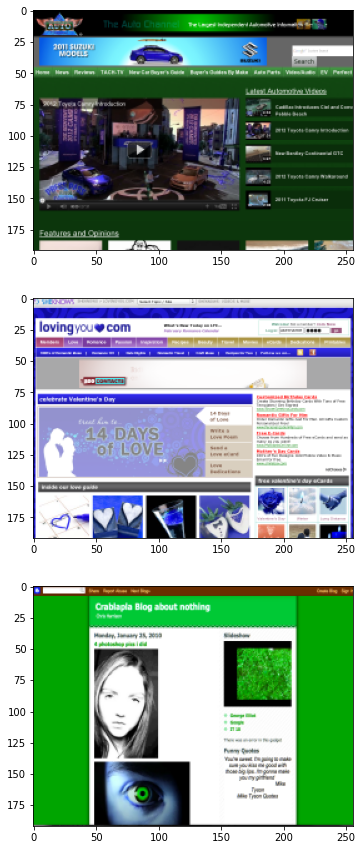

In [11]:
plt.figure(figsize=(25,15))
columns = 3

for i in range(columns):
  plt.subplot(columns, 1, i+1)
  plt.imshow(X_train[i])

The ground truth distribution of human ratings of a given website can be expressed as an empirical probability mass function **p** = [p<sub>s<sub>1</sub></sub>, p<sub>s<sub>2</sub></sub>, ..., p<sub>s<sub>N</sub></sub>] with s<sub>1</sub> &#8804; s<sub>i</sub> &#8804; s<sub>N</sub>, where s<sub>i</sub> denotes the i-th score bucket and N denotes the total number of buckets. In this case, s<sub>1</sub>=1 and s<sub>N</sub>=9.


In [12]:
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
score_values = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])

y_train = []

for i in range(0, len(train_scores)):
  y_temp = np.histogram(train_scores[i], bins=bins)[0]
  y_train.append(y_temp / len(train_scores[i]))
  del y_temp

y_train = np.array(y_train)

y_val = []

for i in range(0, len(test_scores)):
  y_temp = np.histogram(test_scores[i], bins=bins)[0]
  y_val.append(y_temp / len(test_scores[i]))
  del y_temp

y_val = np.array(y_val)


Display shapes to check everything is ok

In [13]:
ntrain = len(X_train)
nval = len(X_val)

print('Shape of X_train is: ', X_train.shape)
print('Shape of X_val is: ', X_val.shape)
print('Shape of y_train is: ', y_train.shape)
print('Shape of y_val is: ', y_val.shape)

Shape of X_train is:  (300, 192, 256, 3)
Shape of X_val is:  (98, 192, 256, 3)
Shape of y_train is:  (300, 9)
Shape of y_val is:  (98, 9)


Construct the CNN. The task is to predict the user aesthetics score distribution for a website. We will use [NIMA-MobileNet](https://arxiv.org/pdf/1709.05424.pdf) as our base network. This network is pretrained on AVA dataset (containing 255k image with aesthetic quality ratings) for the neural image assessment task.

In [75]:
from keras.applications.mobilenet import MobileNet
from keras import optimizers
from keras import regularizers
from keras.layers import GlobalMaxPooling2D, Dense, Dropout, Flatten
from keras.models import Model

input_shape = X_train[0].shape

base_model = MobileNet(include_top=False, weights='imagenet', pooling='avg', input_shape=input_shape)

x = base_model.output
x = Dropout(0.6)(x) 
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.load_weights('./pretrained-models/mobilenet_weights.h5')

model.layers.pop()
outputs = Dense(9, activation='softmax')(model.layers[-1].output)
model = Model(inputs=model.input, outputs=outputs)

model.summary()


c:\Users\Abraham\Proyectos\website-aesthetics-research\.venv\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 192, 256, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 193, 257, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 128, 32)       864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 96, 128, 32)       128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 96, 128, 32)       0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 96, 128, 32)       288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 96, 128, 32)       128 

Define the loss function (Earth Mover's Distance)

In [16]:
from keras import backend as K

def earth_mover_loss(y_true, y_pred):
    cdf_ytrue = K.cumsum(y_true, axis=-1)
    cdf_ypred = K.cumsum(y_pred, axis=-1)
    samplewise_emd = K.sqrt(K.mean(K.square(K.abs(cdf_ytrue - cdf_ypred)), axis=-1))
    return K.mean(samplewise_emd)

In [17]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

Compile the model.

In [18]:
epochs = 95
decay = 1e-4 
base_lr = 0.005

sgd = optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(loss=earth_mover_loss, optimizer=sgd, metrics=[earth_mover_loss])

Train the model.

In [19]:
history = model.fit_generator(train_generator, 
                             steps_per_epoch = ntrain // batch_size,
                             epochs = epochs, 
                             validation_data=val_generator,
                             validation_steps=nval // batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/95
9/9 [==============================] - 113s 13s/step - loss: 0.2319 - earth_mover_loss: 0.2319 - val_loss: 0.1578 - val_earth_mover_loss: 0.1578
Epoch 2/95
9/9 [==============================] - 93s 10s/step - loss: 0.2035 - earth_mover_loss: 0.2035 - val_loss: 0.1525 - val_earth_mover_loss: 0.1525
Epoch 3/95
9/9 [==============================] - 95s 11s/step - loss: 0.1920 - earth_mover_loss: 0.1920 - val_loss: 0.1323 - val_earth_mover_loss: 0.1323
Epoch 4/95
9/9 [==============================] - 100s 11s/step - loss: 0.1921 - earth_mover_loss: 0.1921 - val_loss: 0.1454 - val_earth_mover_loss: 0.1454
Epoch 5/95
9/9 [==============================] - 90s 10s/step - loss: 0.1709 - earth_mover_loss: 0.1709 - val_loss: 0.1335 - val_earth_mover_loss: 0.1335
Epoch 6/95
9/9 [==============================] - 101s 11s/step - loss: 0.1762 - earth_mover_loss: 0.1762 - val_loss: 0.1209 - va

Display the learning curves.

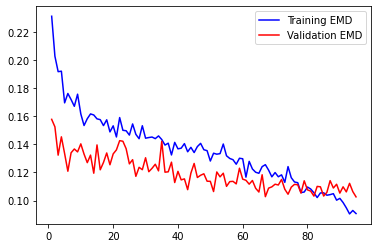

In [20]:

emd = history.history["earth_mover_loss"]
val_emd = history.history["val_earth_mover_loss"]

epochs_x = range(1, len(emd) + 1)

plt.plot(epochs_x, emd, 'b', label='Training EMD')
plt.plot(epochs_x, val_emd, 'r', label='Validation EMD')

plt.legend()

Define a function that calculates Pearson correlation.

In [21]:
from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''
    N = len(x)
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(N-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

Predict aesthetics score of the webpages in the test set. The mean value of the predicted distribution is used as the final aesthetics score.

In [22]:
predictions = []

X_val = X_val / 255.0

for img in X_val:
  img = img.reshape(1, 192, 256, 3)
  pred = model.predict(img)

  predictions.append(float(np.sum(pred[0] * score_values)))

gt_scores = np.array(gt_scores)
predictions = np.array(predictions)

Display some websites of the test set and the predicted aesthetics score.

c:\Users\Abraham\Proyectos\website-aesthetics-research\.venv\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


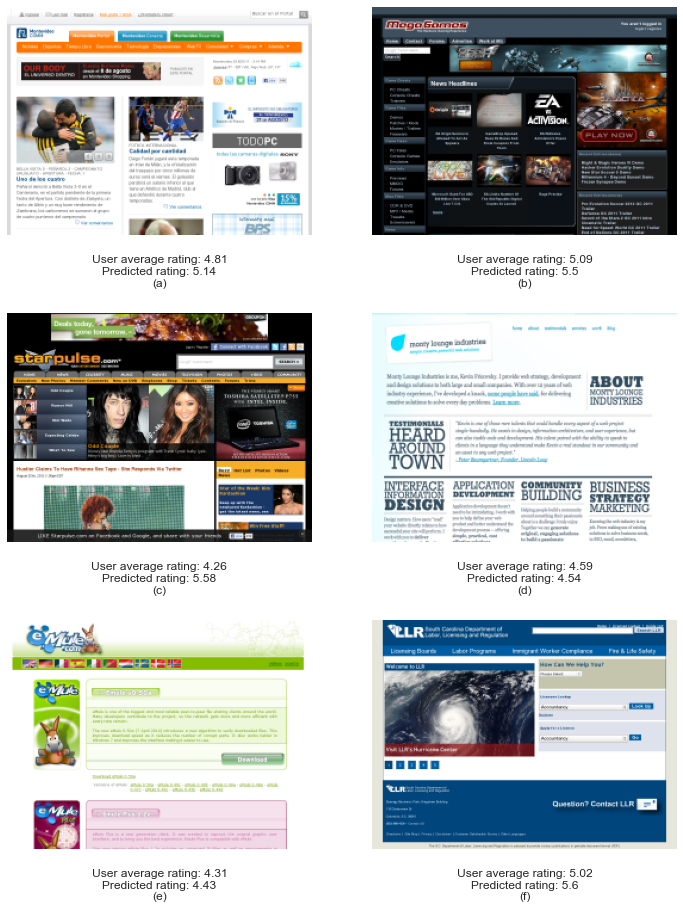

In [83]:
image_ids = [13, 43, 5, 76, 44, 92] # test image IDs sorted in descending order according to the website's aesthetics level

fig = plt.figure(figsize=(12, 16))
i = 1
for id in image_ids:
  if 'english' in test_images[id]:
    path = images_path + '/english_resized/' + test_images[id].rsplit('/', 1)[1] 
  else:
    path = images_path + '/foreign_resized/' + test_images[id].rsplit('/', 1)[1]
 
  plt.subplot(len(image_ids)/2, 2, i)
  img = mping.imread(path)
  plt.title('User average rating: ' + str(np.round(gt_scores[id],2)) + '\nPredicted rating: ' + str(np.round(predictions[id],2)) + '\n(' + chr(97+i-1) + ')', y=-0.25)
  plt.axis('off')
  plt.imshow(img)
    
  i += 1

plt.show()

Create a scatterplot to check the relationship between ground truth and predicted scores.

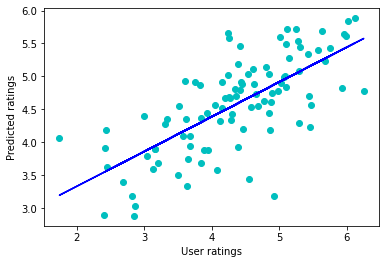

In [24]:
from numpy.polynomial.polynomial import polyfit
b, m = polyfit(gt_scores, predictions, 1)

fig = plt.figure()
plt.scatter(gt_scores, predictions, c='c')
plt.plot(gt_scores, b + m * gt_scores, '-', c='b')
plt.xlabel('User ratings')
plt.ylabel('Predicted ratings')

plt.show()

Calculate the Pearson correlation and the RMSE between ground truth and predicted scores.

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt


corr, p, lo, hi = pearsonr_ci(gt_scores, predictions)
print('Pearsons correlation: r=%.2f, p=%.2e, CI=[%.2f, %.2f]' % (corr, p, lo, hi))
rmse_test = sqrt(mean_squared_error(gt_scores, predictions))
print('RMSE: %.3f' % rmse_test)

Pearsons correlation: r=0.71, p=4.24e-16, CI=[0.59, 0.79]
RMSE: 0.716


Plot the distribution of ground truth scores and the distribution of predictions.

c:\Users\Abraham\Proyectos\website-aesthetics-research\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Abraham\Proyectos\website-aesthetics-research\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


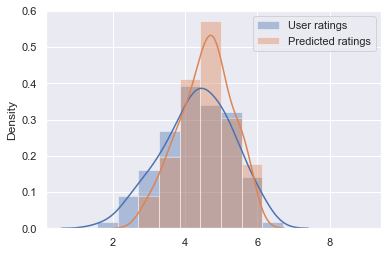

In [26]:
import seaborn as sns

fig = plt.figure()
sns.set(color_codes=True)

bins = np.linspace(1, 9, num=15)

sns.distplot(gt_scores, bins=bins, label='User ratings')

sns.distplot(predictions, bins=bins, label='Predicted ratings')

plt.legend()


plt.show()

In [66]:
print(type(model))
print(type(model.get_layer))

<class 'keras.engine.training.Model'>
<class 'method'>


In [79]:
print(isinstance(model, Model))
print(type(model))
print(type(model))
isinstance(model, Model)

print(model.get_layer)
print(model.inputs)
##print("TensorFlow version:", tf.__version__)
##print("Keras version:", Keras.__version__)

True
<class 'keras.engine.training.Model'>
<class 'keras.engine.training.Model'>
<bound method Network.get_layer of <keras.engine.training.Model object at 0x00000181EE42A048>>
[<tf.Tensor 'input_5:0' shape=(?, 192, 256, 3) dtype=float32>]


In [90]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib import cm



def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Convertir img_array a tensor
    img_array = tf.convert_to_tensor(img_array)
    
    if isinstance(model.inputs, list):
        grad_model = Model(
            inputs=model.inputs, outputs=[model.get_layer(last_conv_layer_name).output, model.output]
        )
    else:
        grad_model = Model(
            inputs=[model.inputs], outputs=[model.get_layer(last_conv_layer_name).output, model.output]
        )



    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Asegurarse de que el modelo está definido
from tensorflow.keras.applications import MobileNet

model = MobileNet(weights='imagenet', include_top=True)
model.layers[-1].activation = None  # Quitar la activación softmax

img_path = "./datasets/rating-based-dataset/preprocess/resized/english_resized/6.png" # Path to your image
last_conv_layer_name = "conv_pw_1" # Name of the last convolutional layer

img_array = get_img_array(img_path, size=(224, 224))
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
display_gradcam(img_path, heatmap)


TypeError: object of type 'ReLU' has no len()